# Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file.
<br>
The company is looking at prospective properties to buy to enter the market. 

## Objective 

To build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

### Step 1 : Import Data

In [72]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [73]:
#read data set
housing = pd.read_csv("train.csv")

In [74]:
#explore the data set
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

We have a maximum of 1460 entries (rows) and 81 columns.
A quick look into info indicates most of the columns have no missing values. We can drop/treat the columns with missing values as part of missing value treatment exercise later.

In [75]:
#quick sneak into data set
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [76]:
#check the percentage of missing values
missing_percentage =round(100*(housing.isnull().sum()/len(housing.index)), 2).sort_values(ascending=False)

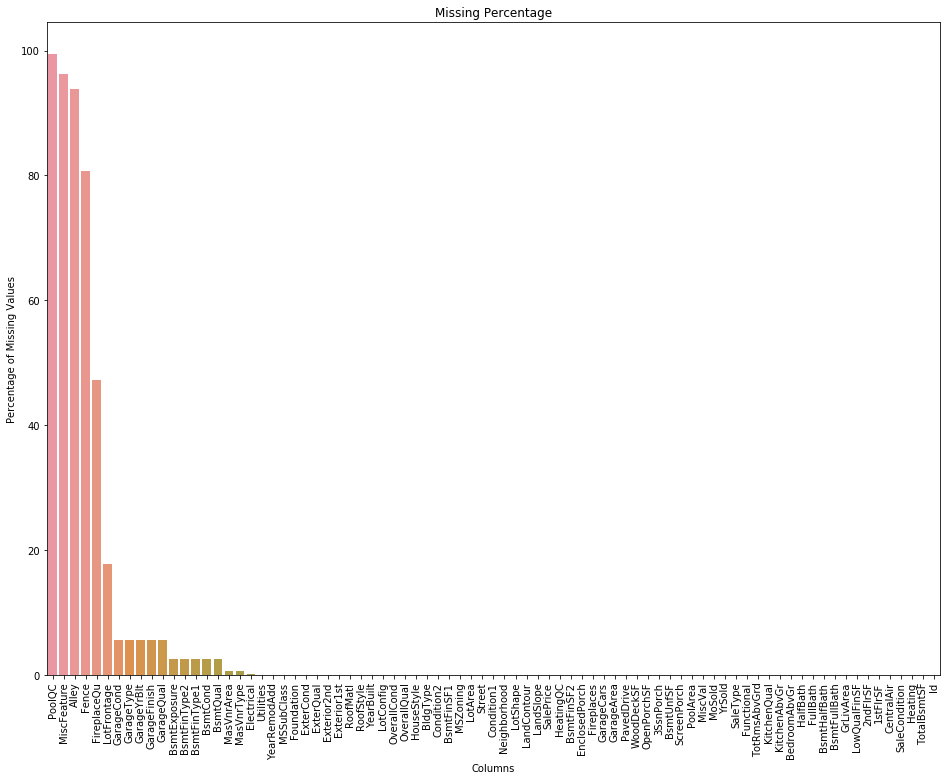

In [77]:
#Plotting the missing percentage of columns
plt.figure(figsize=(16,12))
plt.title('Missing Percentage')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
sns.barplot(missing_percentage.index,missing_percentage.values)
plt.show()

As seen from the above graph, we have the following columns whose missing percentage is greater than 40% (chosen as cutoff for this assignment)
1. PoolQC
2. MiscFeature
3. Alley
4. Fence
5. FireplaceQu

Hence it is best to ***drop*** these columns

### Step 2 : Data Preparation

In [78]:
#Dropping columns with high missing percentage
col_to_drop = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
housing_df = housing.drop(col_to_drop,axis=1)

In [79]:
#Finding the unique values amongst each columns
unique_values=housing_df.nunique().sort_values()

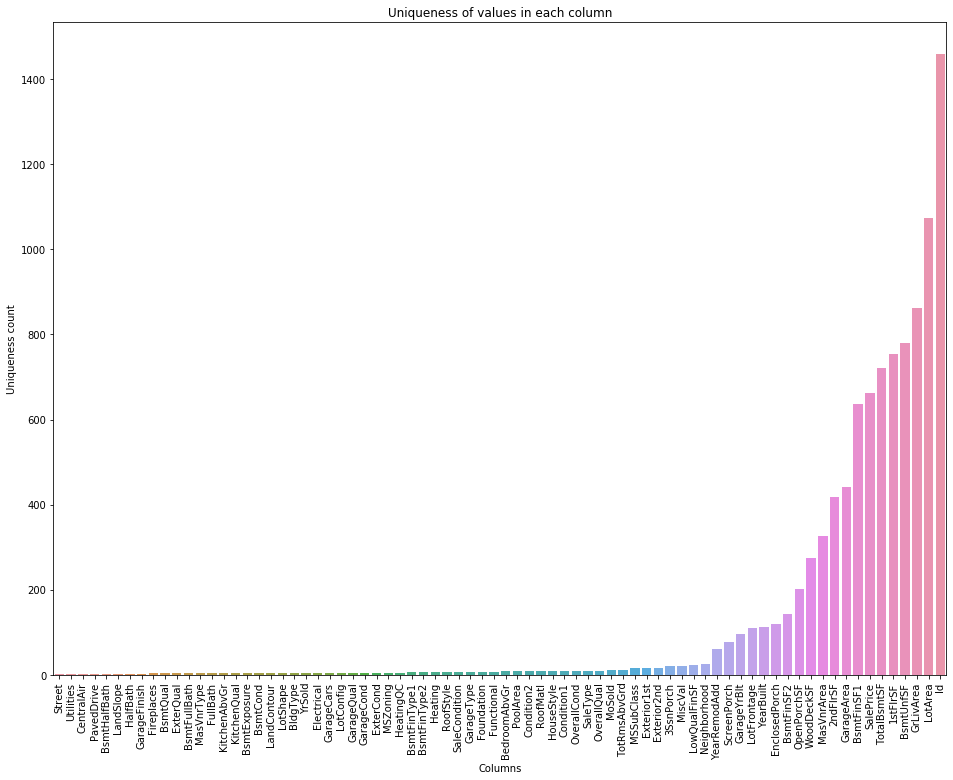

In [80]:
#Plotting the unique values of columns
plt.figure(figsize=(16,12))
plt.title('Uniqueness of values in each column')
plt.xlabel('Columns')
plt.ylabel('Uniqueness count')
plt.xticks(rotation=90)
sns.barplot(unique_values.index,unique_values.values)
plt.show()

As seen from above graph, none of the columns have unique value of less than 1. Hence the dataset provided is ***unique***

### Univariate Analysis

We are to perform univariate analysis on categorical columns and determine the data distribution for each column.

***Skewness Check***

In [81]:
#Select only the columns whose data type is object
cat_columns = housing_df.select_dtypes(include='object').columns
print(cat_columns)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


*We also have additional categorical columns which are expressed in numbers.*
<br>*Those should be considered as well for skewness check*
<br>

Upon inspecting the data dictionary, the following columns are also considered
1. MSSubClass
2. OverallQual
3. OverallCond

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


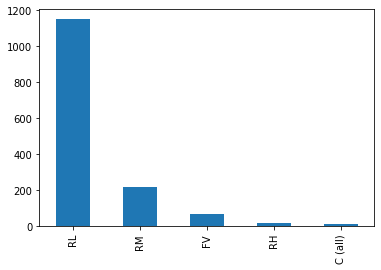

Pave    1454
Grvl       6
Name: Street, dtype: int64


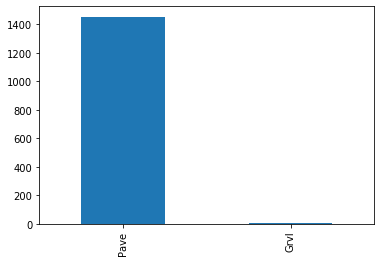

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


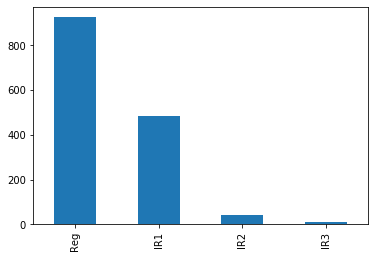

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


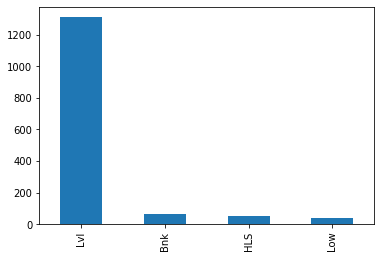

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


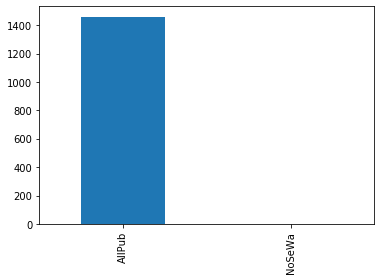

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


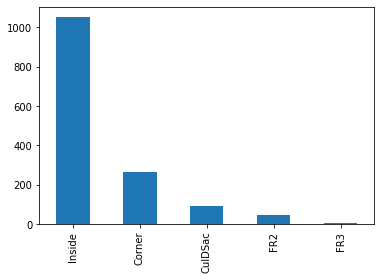

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


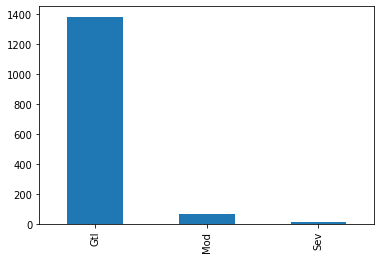

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


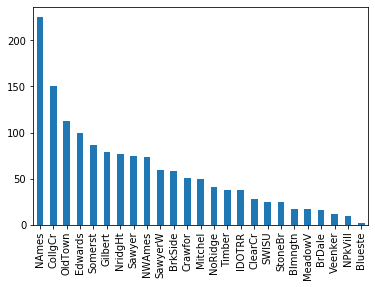

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


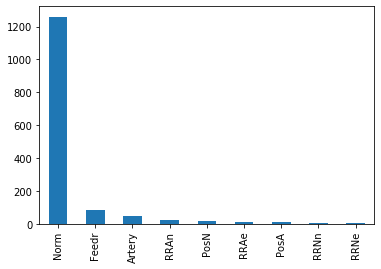

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


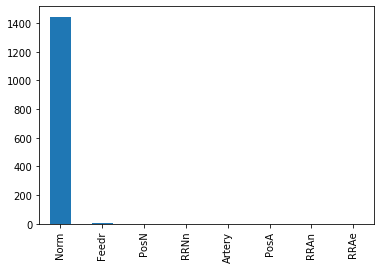

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


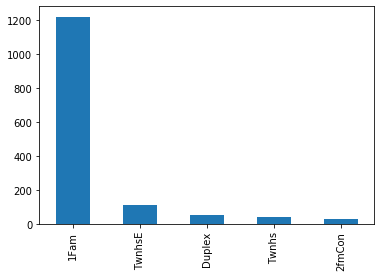

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


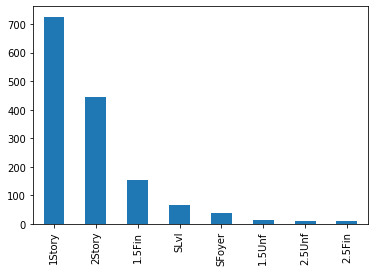

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64


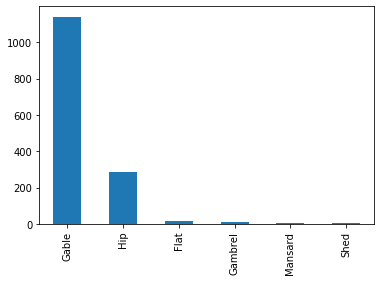

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
ClyTile       1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64


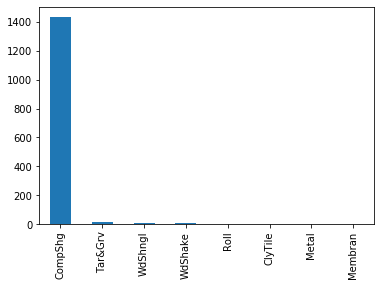

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64


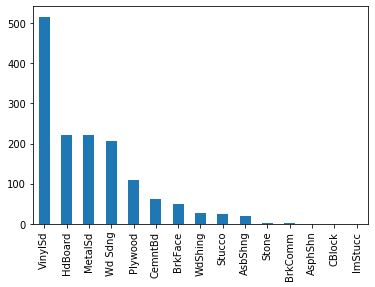

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64


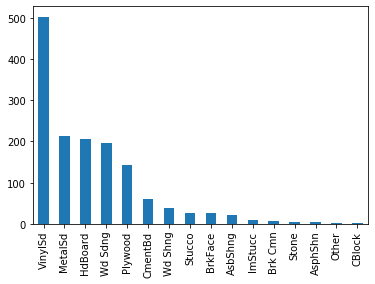

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


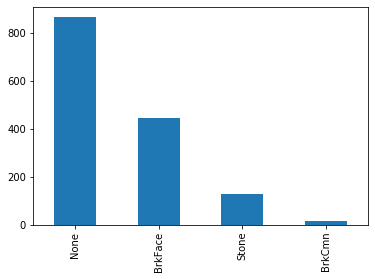

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


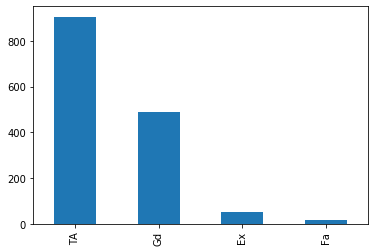

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


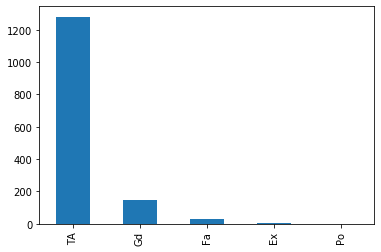

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64


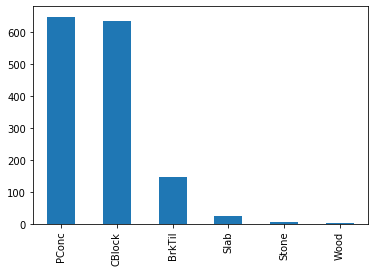

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64


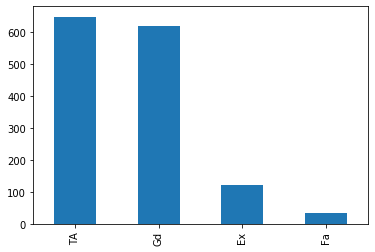

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64


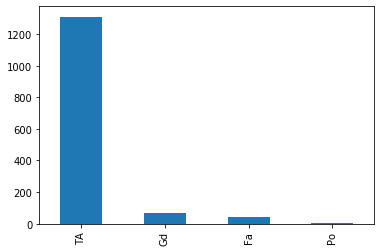

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64


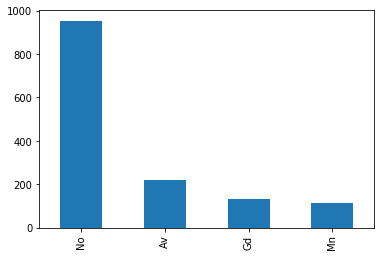

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64


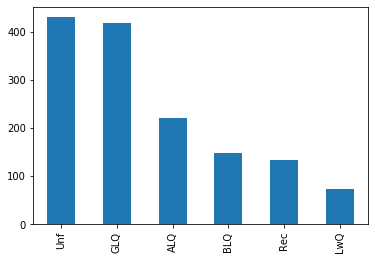

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


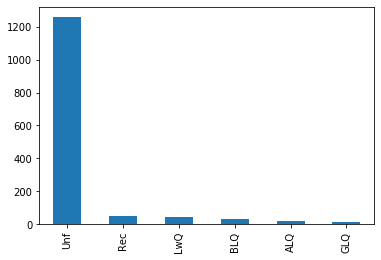

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


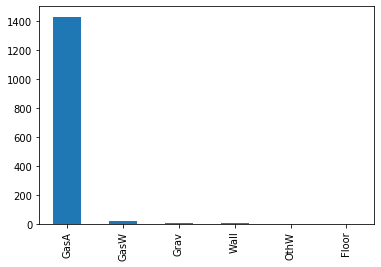

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


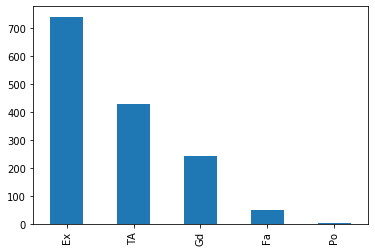

Y    1365
N      95
Name: CentralAir, dtype: int64


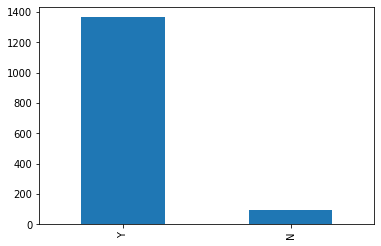

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


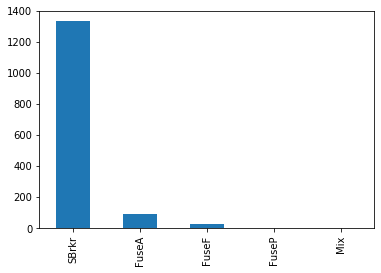

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


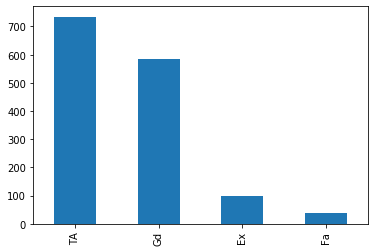

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


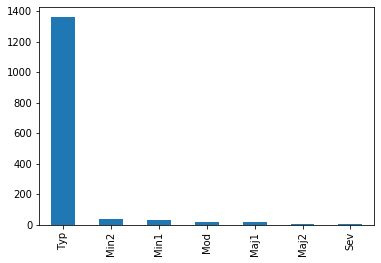

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64


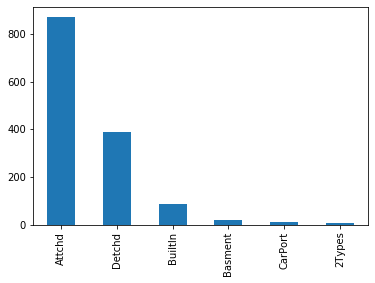

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64


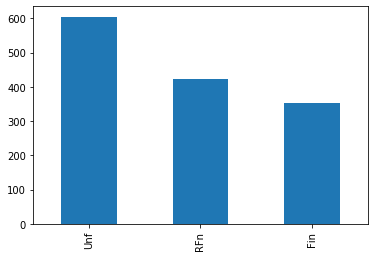

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64


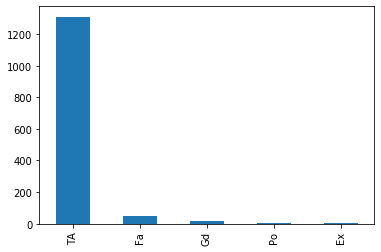

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


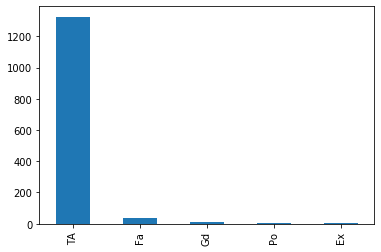

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64


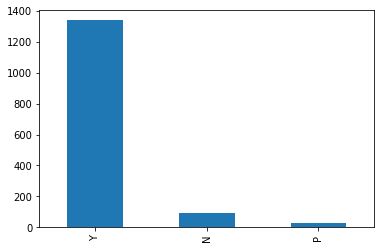

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64


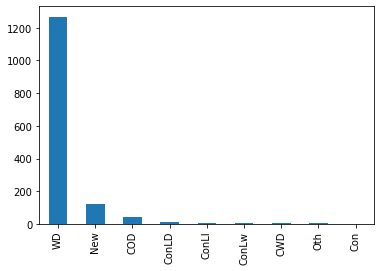

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


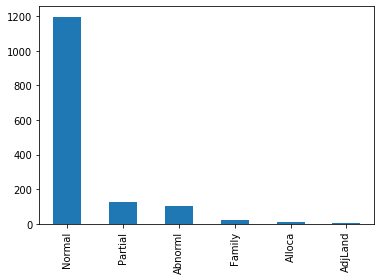

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


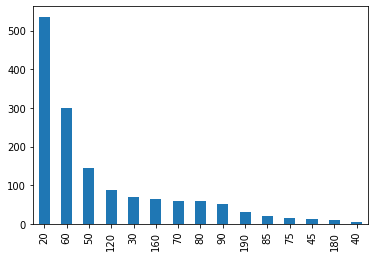

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


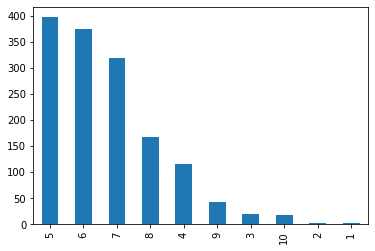

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64


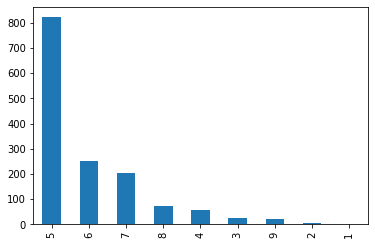

In [82]:
skew_check = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition','MSSubClass','OverallQual','OverallCond']

for i in skew_check:
    print(housing_df[i].value_counts())
    housing_df[i].value_counts().plot(kind='bar')
    plt.show()

### Observations from the Univariate Bar Plots

As seen from above skewness plots and counts, the columns whose skewness is greater than 90% are listed below

1. Street (99% skewed)
2. Utilities (99% skewed)
3. Condition2 (99% skewed)
4. RoofMatl (98% skewed)
5. Heating (98% skewed)
6. GarageCond (96% skewed)
7. LandSlope (95% skewed)
8. GarageQual (95% skewed)
9. CentralAir (93% skewed)
10. Functional (93% skewed)
11. PavedDrive (91% skewed)
12. Electrical(91% skewed)

We are to drop the columns whose skewness percentage is greater than or equal to 95%

In [83]:
#Drop highly skewed columns
skew_col_drop = ['Street','Utilities','Condition2','RoofMatl','Heating','GarageCond','LandSlope']
housing_df.drop(skew_col_drop,axis=1,inplace=True)

#### Missing Value Treatment on Categorical Columns

The following categorical columns have missing values. It is imperative to treat them

1. MasVnrType
2. BsmtQual
3. BsmtCond
4. BsmtExposure
5. BsmtFinType1
6. BsmtFinType2
7. Electrical
8. GarageType
9. GarageFinish
10. GarageQual


***Important Note*** <br>
1. The columns listed above are all Categorical Variables
2. The null values in those categorical variables can be replaced with a string 'Ignorable'
3. When these columns are represented in dummies, the column created for value 'Ignorable' can be dropped

In [84]:
#Given that these above mentioned column needs to be converted into dummies at later stage , replacing all null values with a string Ignorable, 
#so that this dummy column can be dropped later
housing_df.MasVnrType.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.BsmtQual.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.BsmtCond.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.BsmtExposure.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.BsmtFinType1.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.BsmtFinType2.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.Electrical.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.GarageType.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.GarageFinish.replace(to_replace=np.nan,value='Ignorable',inplace=True)
housing_df.GarageQual.replace(to_replace=np.nan,value='Ignorable',inplace=True)

### Performing Analysis on Numerical Data

In [85]:
#Identifying the statistical context of numerical variables
#Select only the columns whose data type is float or int
num_columns = housing_df.select_dtypes(exclude='object').columns
print(num_columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [86]:
#Splitting the numerical columns into two sections for better understanding of statitstical date
num_col1 = ['LotFrontage', 'LotArea','YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr']

num_col2= ['KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

housing_df[num_col1].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000


In [87]:
housing_df[num_col2].describe()

,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Based on the statistical information available from the above two tables, looks like the following columns have outliers in them

1. LotArea
2. EnclosedPorch
3. 3SsnPorch
4. ScreenPorch
5. PoolArea
6. MiscVal

This info provides a head start when we perform outlier treatment in the later part of the code.

### Bivariate Analysis

Now we are going to analyse how various columns figure against our target variable SalesPrice

In [ ]:
# plot Salesprice with all other variables

plt.figure()
for col in range(1, housing_df.shape[1]):
    plt.scatter(housing_df["SalePrice"], housing_df.iloc[:, col])
    plt.ylabel(housing_df.columns[col])
    plt.xlabel("Sales Price")
    plt.show()

From the above scatter plots, we can see the following numerical columns are linearly related to target variable SalePrice. (Purely from image perspective)

1. LotFrontage
2. YearBuilt
3. YearRemodAdd
4. MasVnrArea
5. BsmtFinSF1
6. BsmtUnfSF
7. TotalBsmtSf
8. 1stFlrSF
9. 2ndFlrSF
10. GrLivArea
11. GarageYrBlt
12. GarageArea
13. WoodDeckSF
14. OpenPorchSF

These features can be a good indicator to understand the model that we built is in line with the features listed here.

In [88]:
#Imputing None in Numerical Columns GarageYrBlt, LotFrontage, MasVnrArea column with median value
housing_df['GarageYrBlt'].fillna((housing_df['GarageYrBlt'].median()), inplace=True)
housing_df['LotFrontage'].fillna((housing_df['LotFrontage'].median()), inplace=True)
housing_df['MasVnrArea'].fillna((housing_df['MasVnrArea'].median()), inplace=True)

In [89]:
#checking the info again
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 69 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
LotShape         1460 non-null object
LandContour      1460 non-null object
LotConfig        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1460 non-null object
MasVnrArea       1460 non-null float64
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 no

As seen from above info, we don't have any missing values across columns

### Bivariate Analysis on Categorical Columns

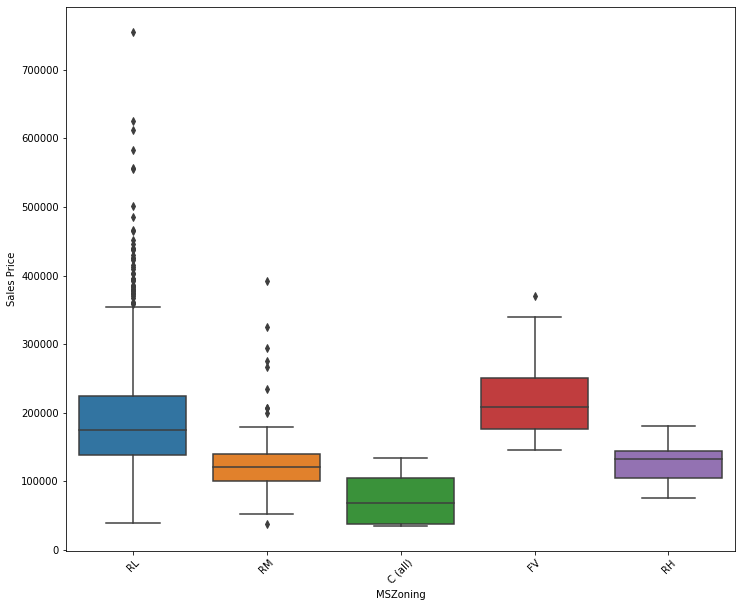

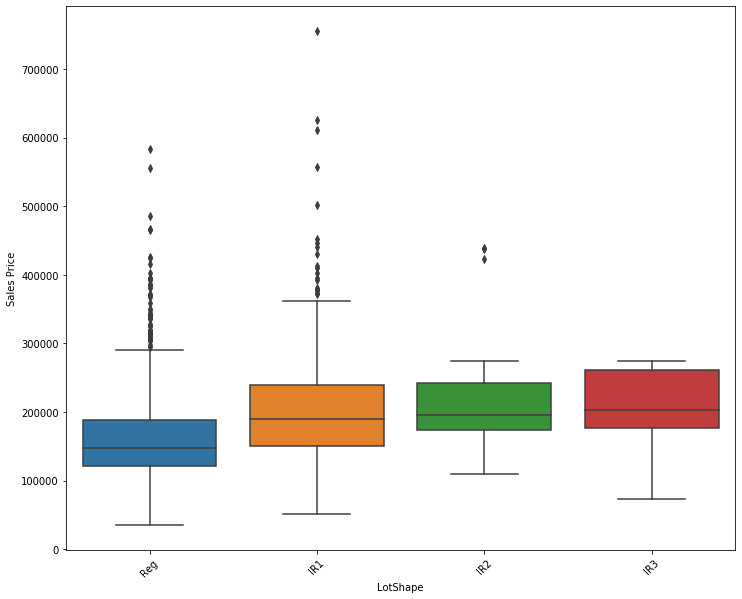

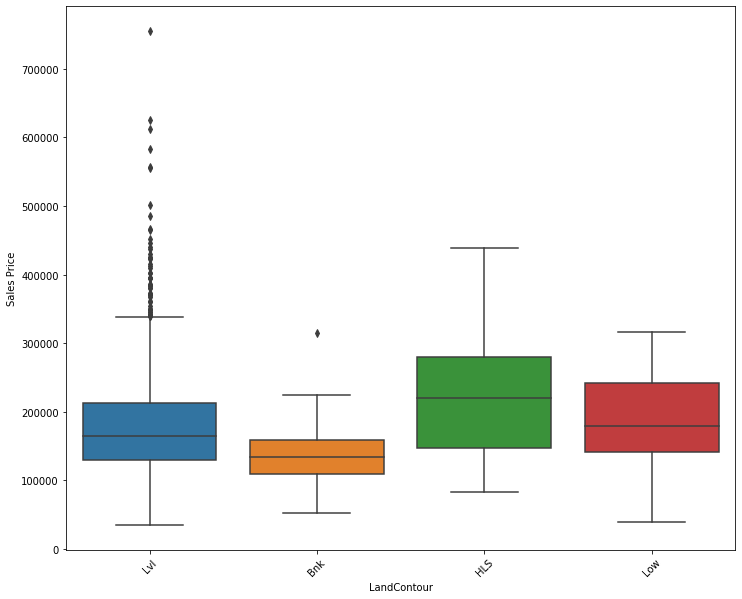

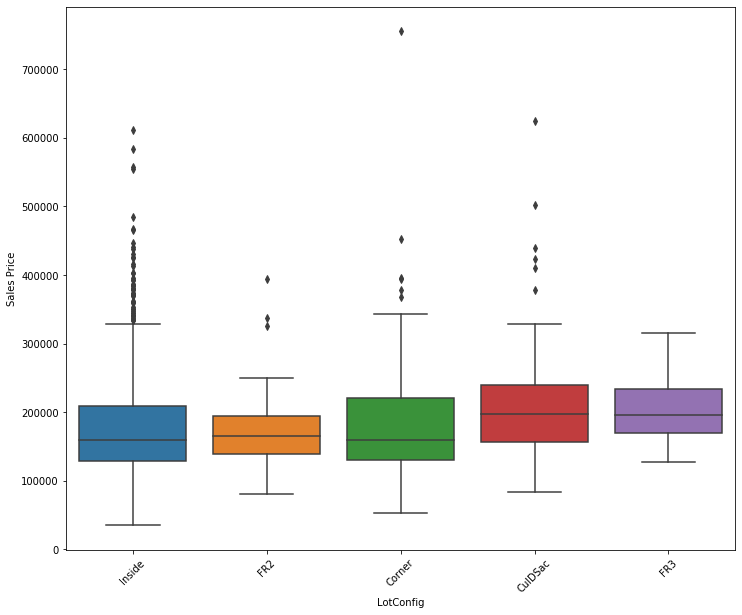

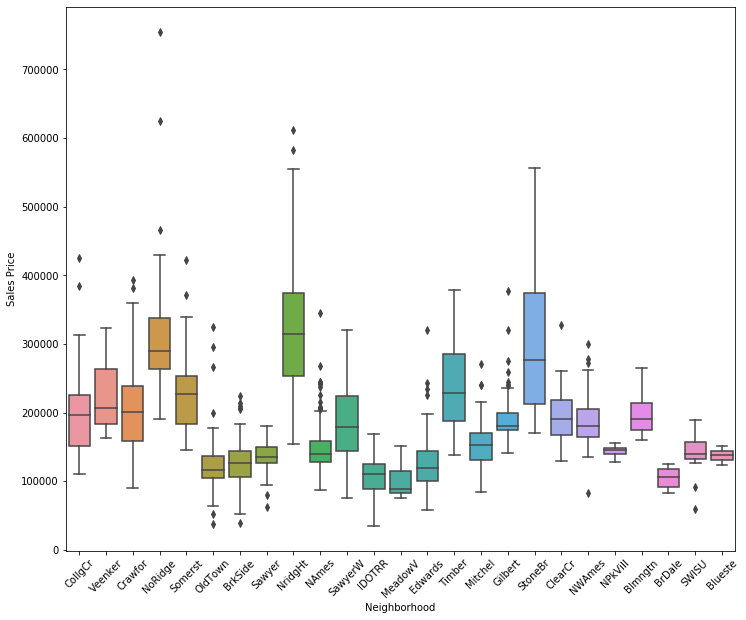

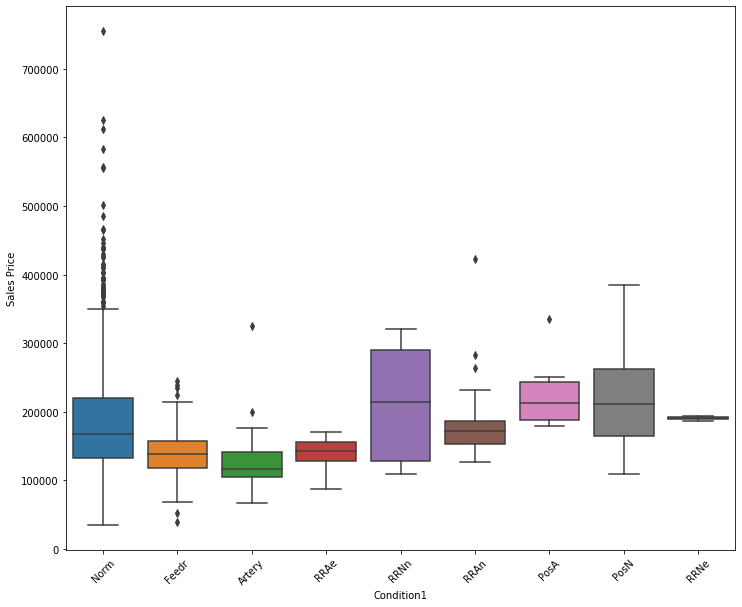

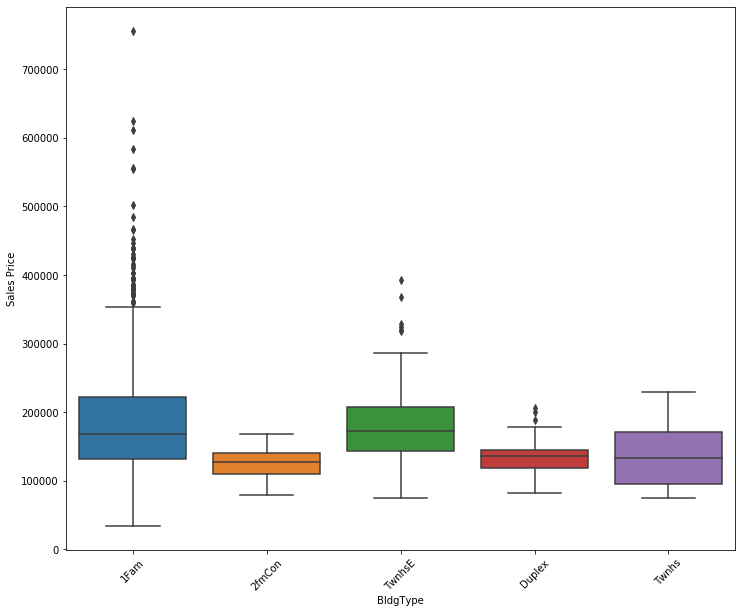

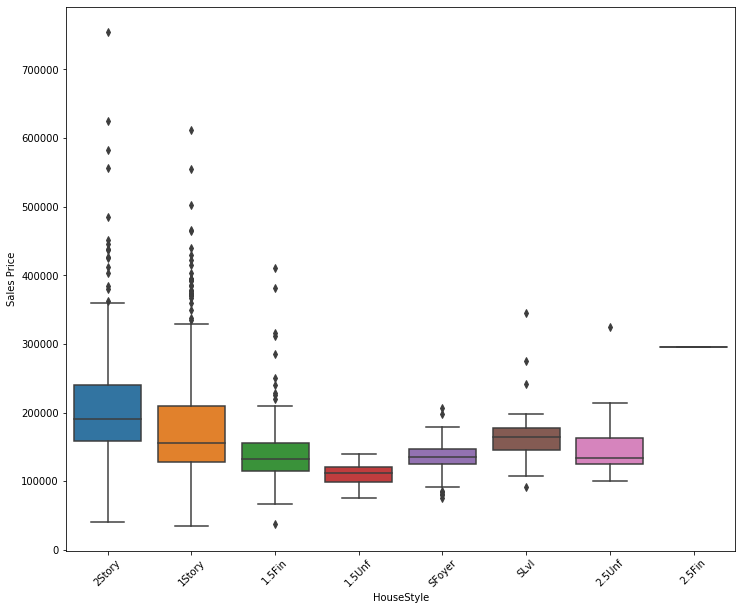

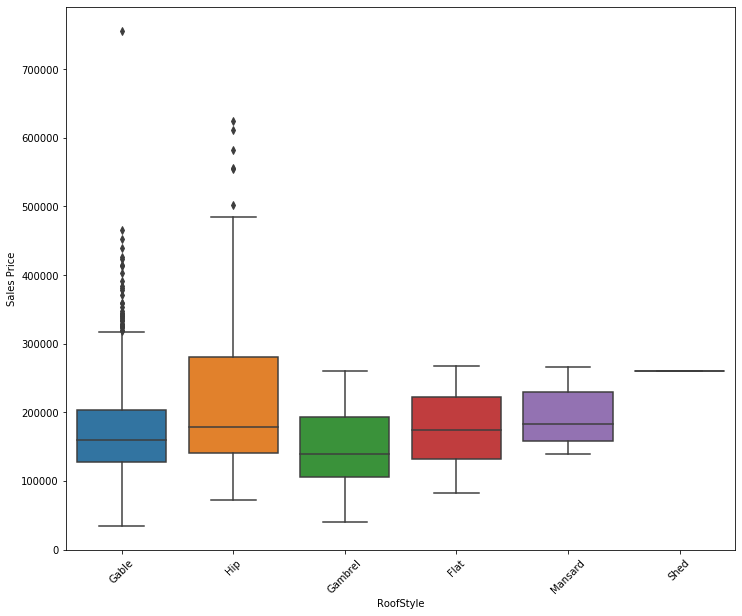

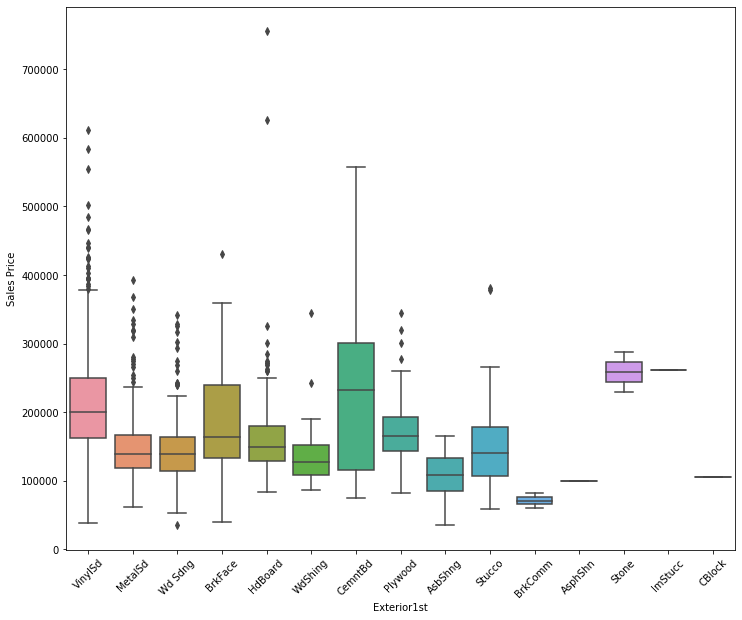

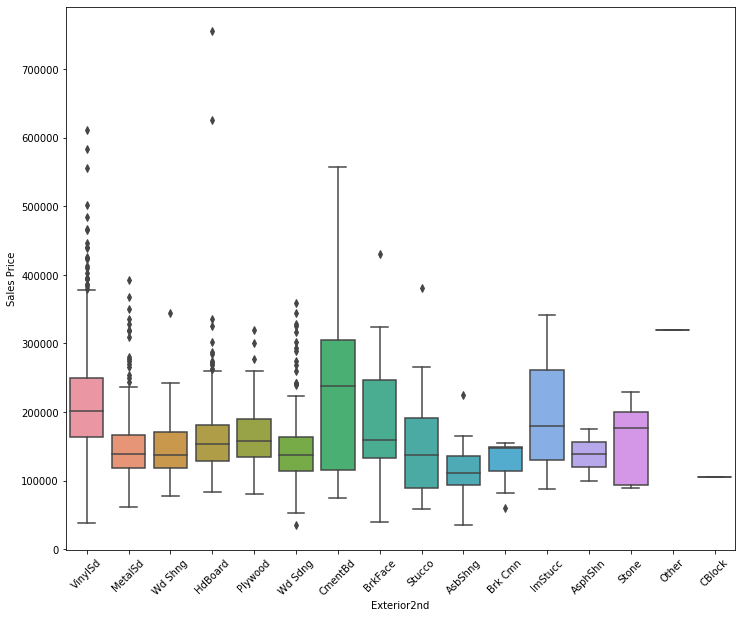

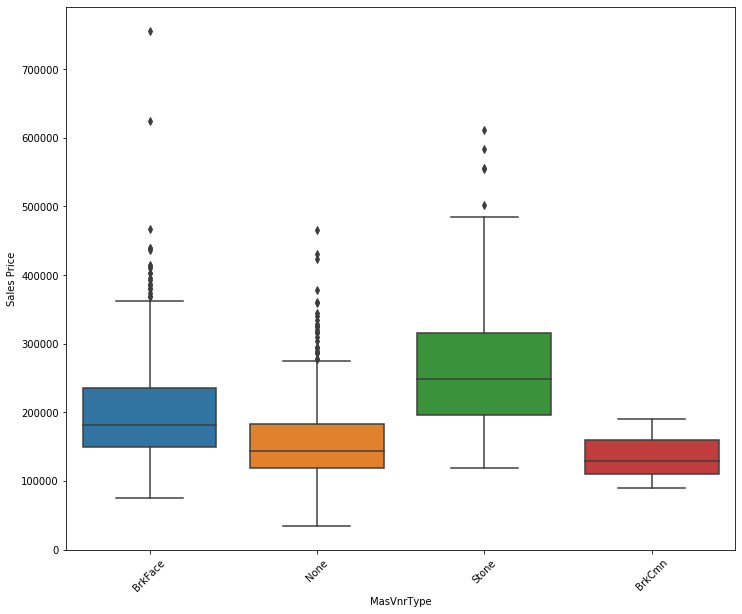

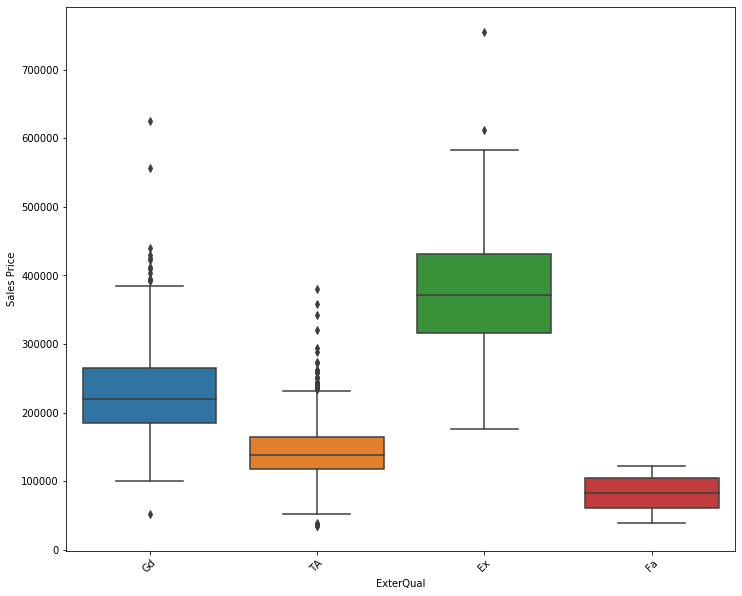

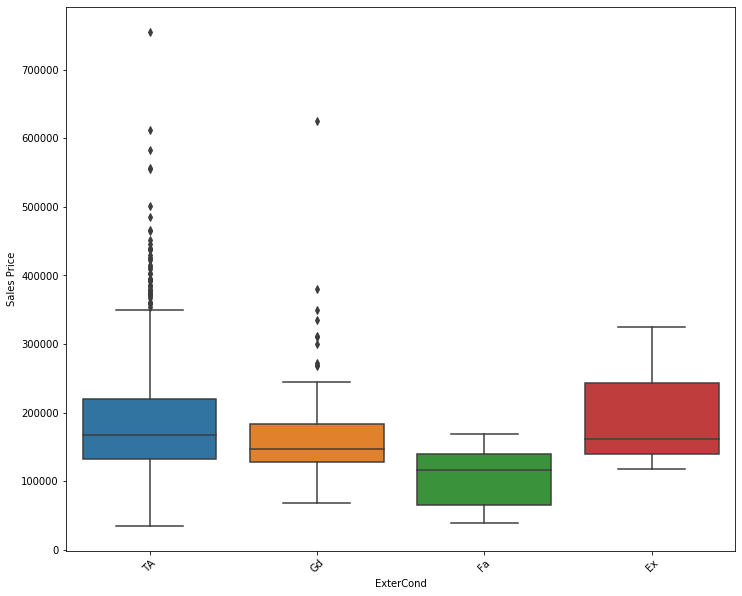

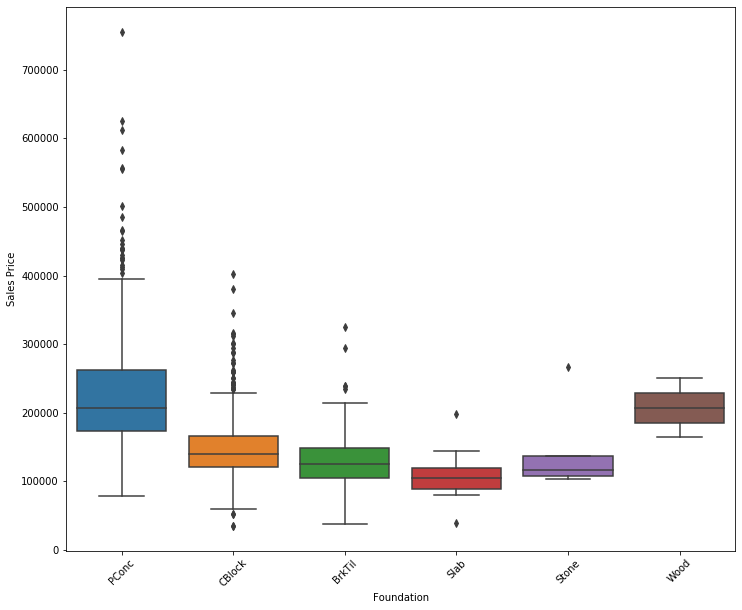

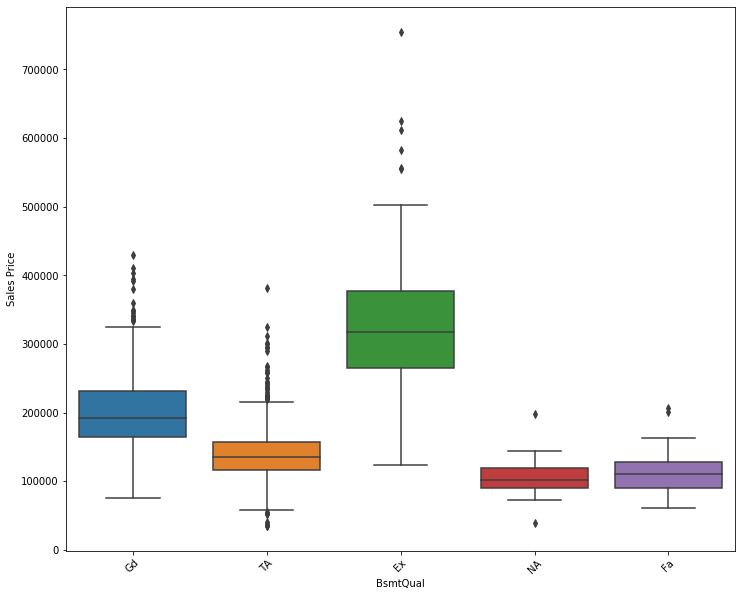

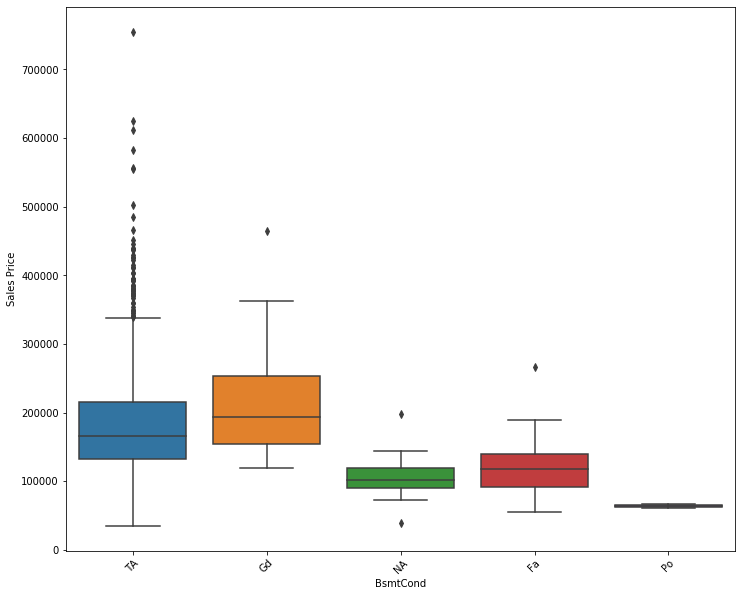

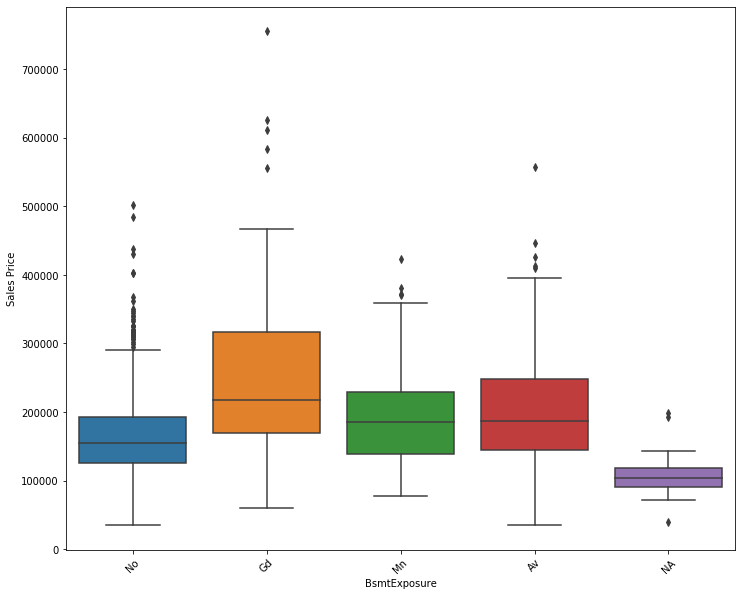

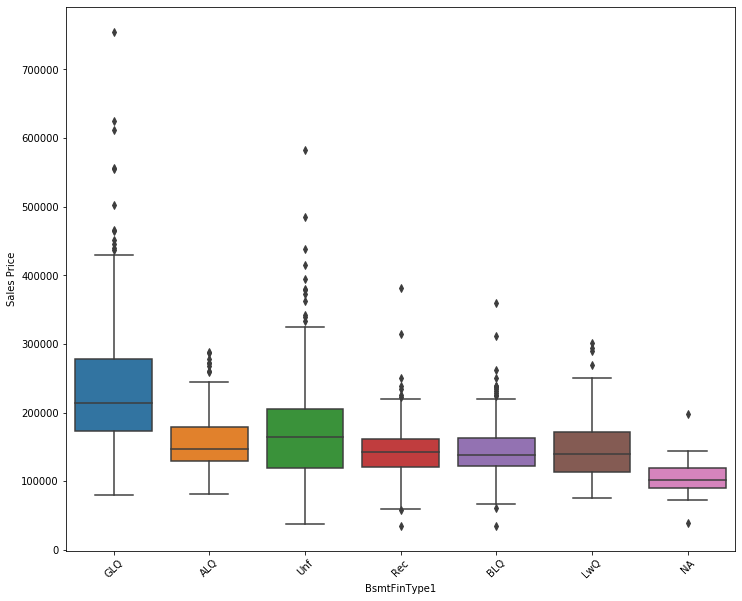

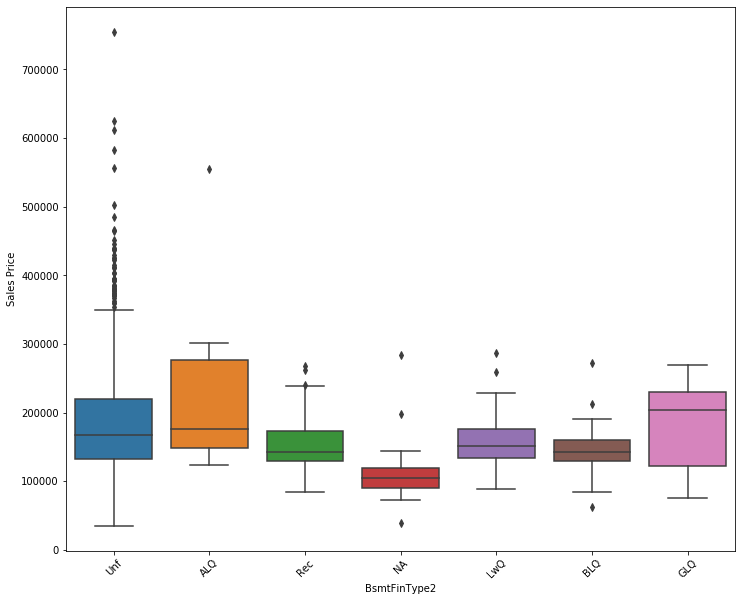

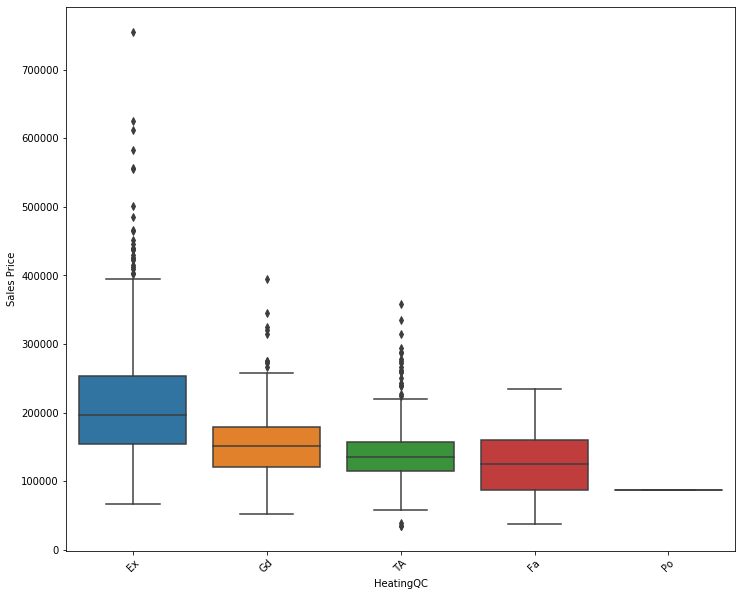

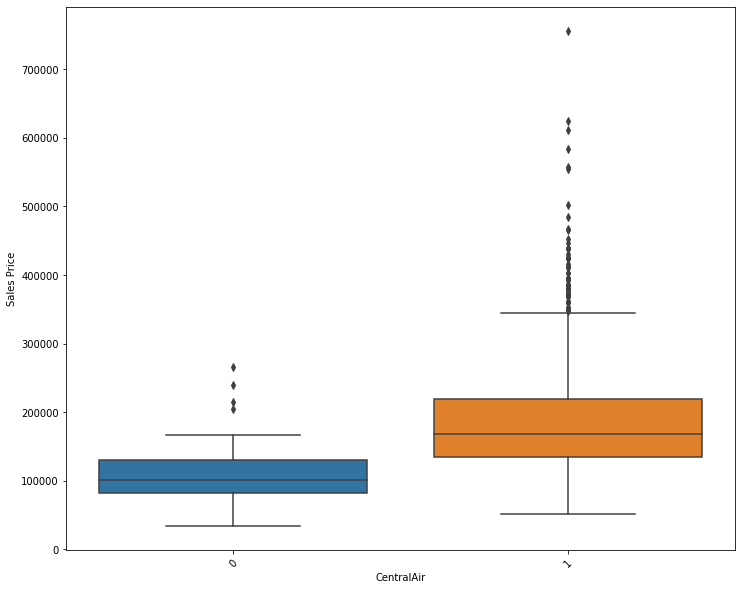

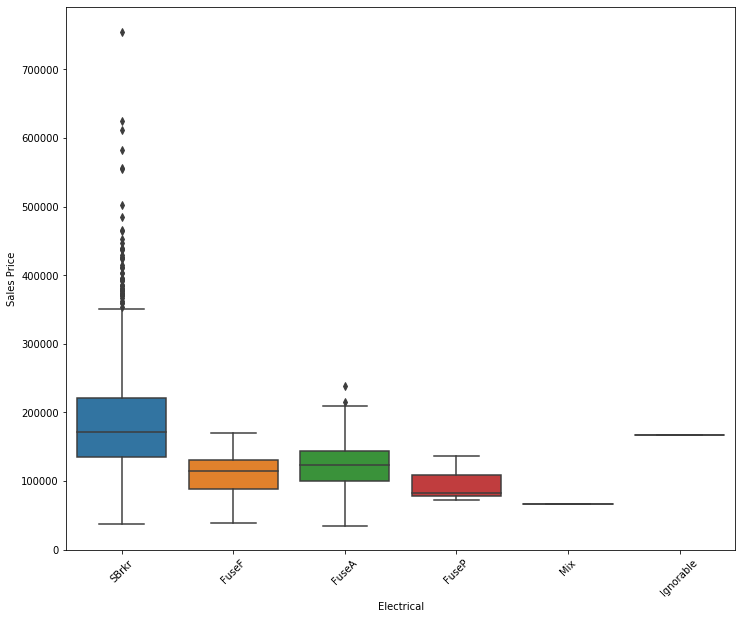

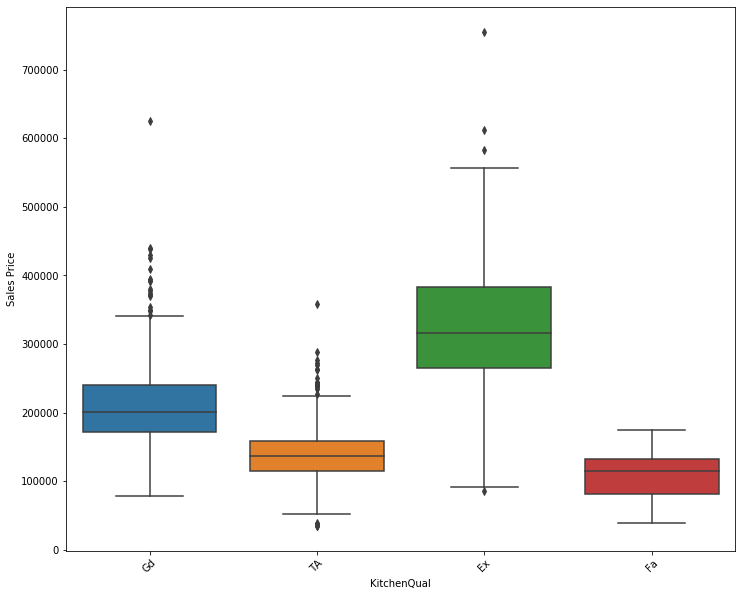

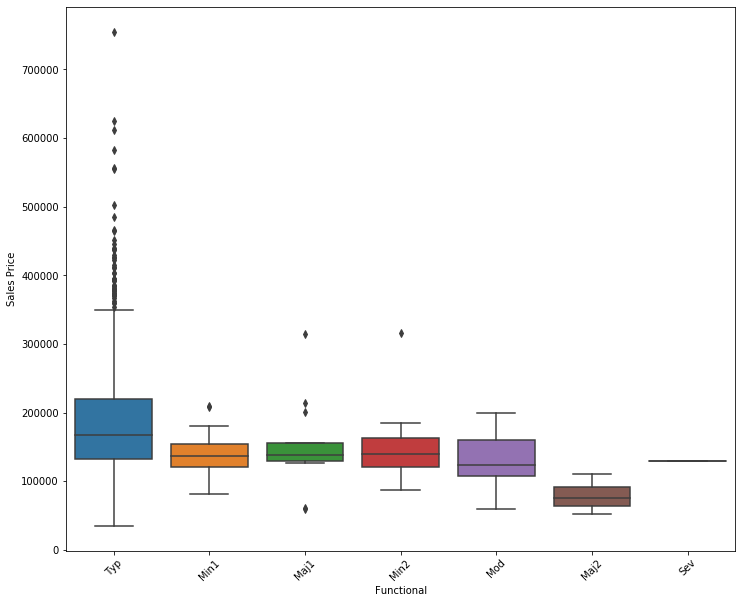

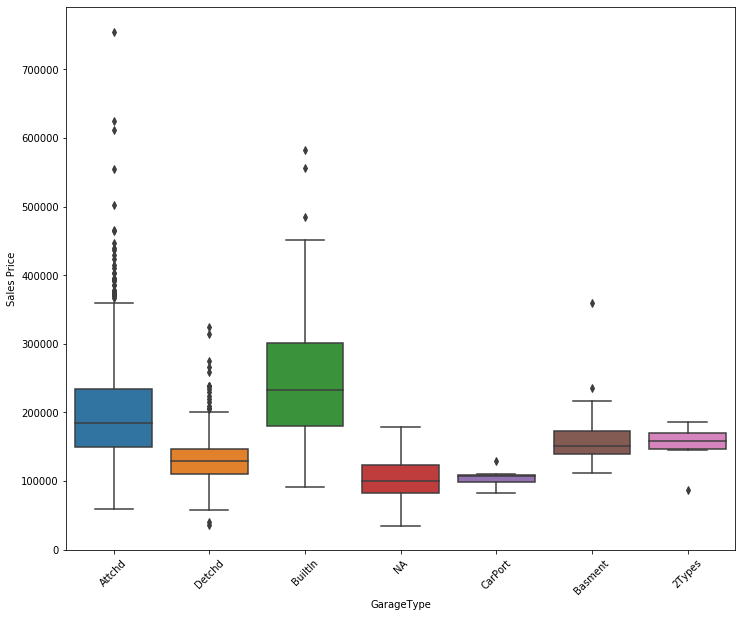

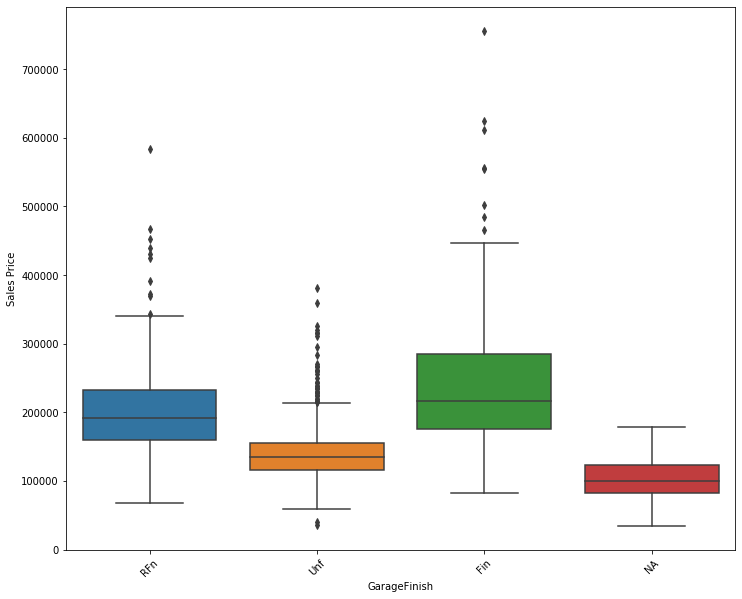

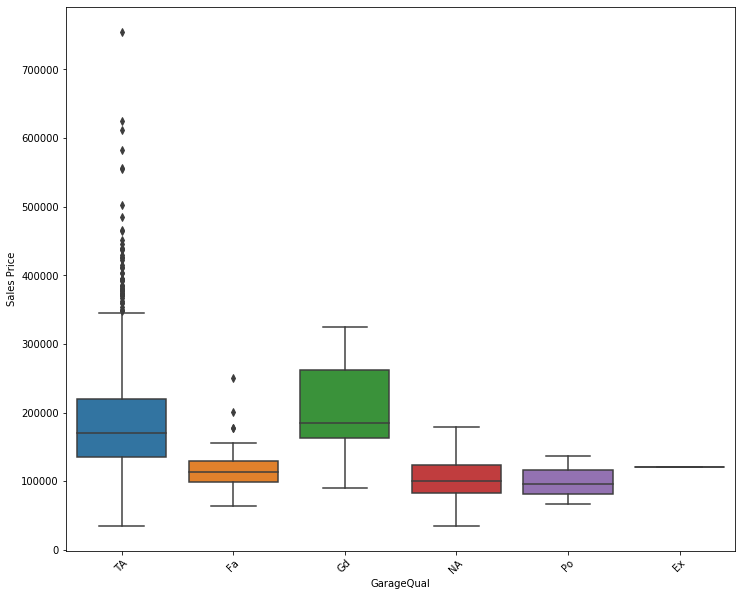

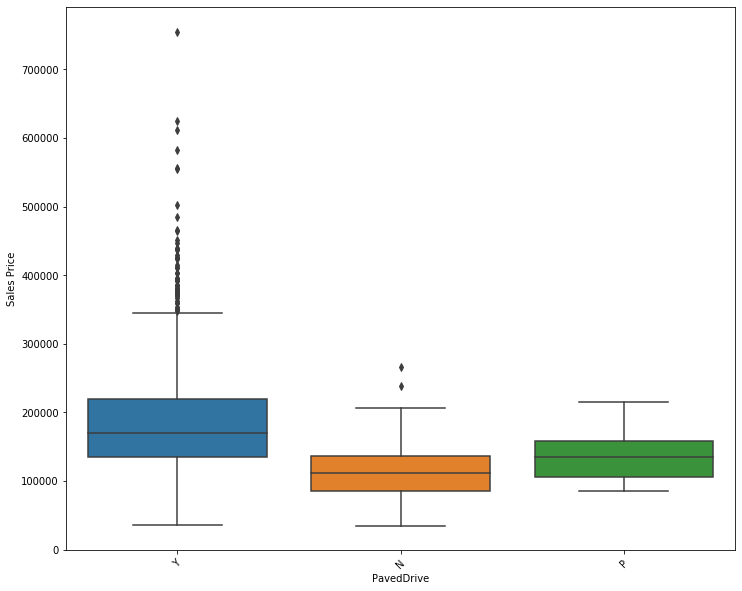

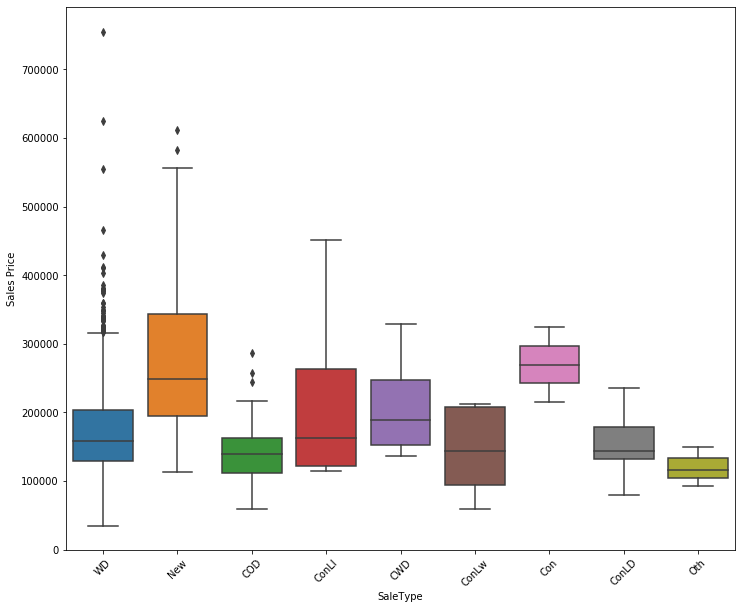

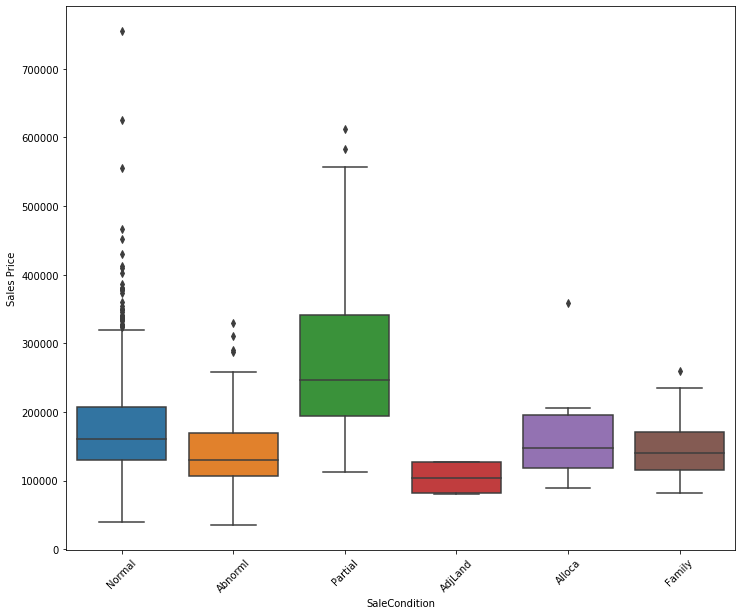

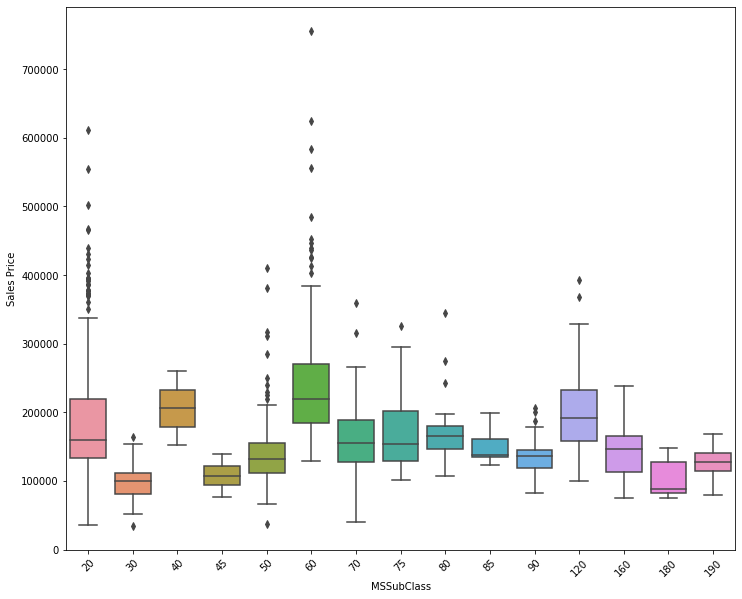

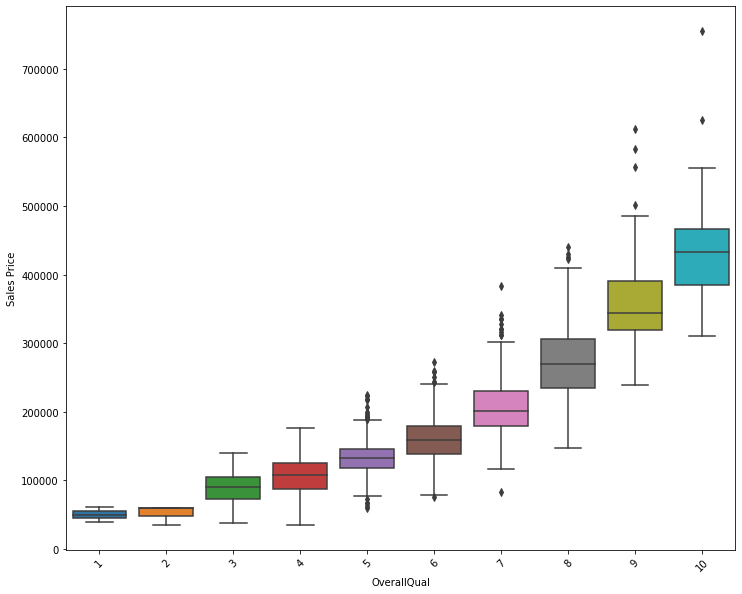

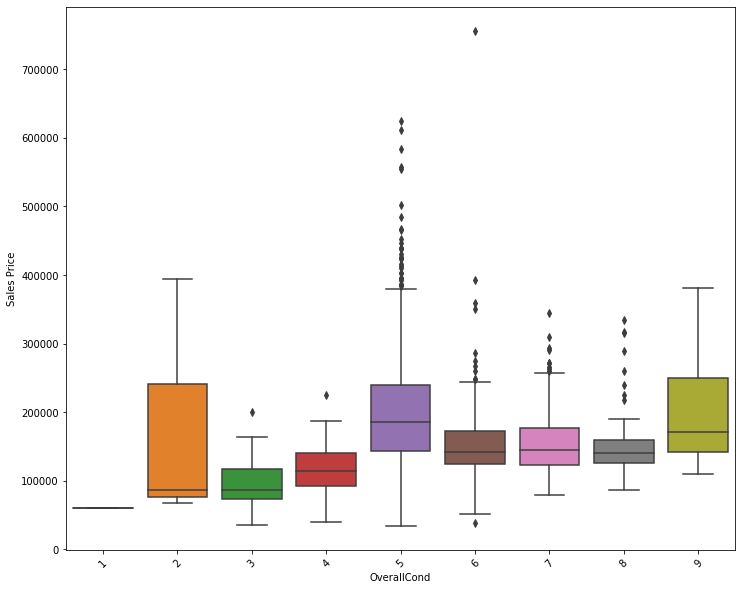

In [171]:
#list of categorical column names
categorical = ['MSZoning', 'LotShape', 'LandContour','LotConfig', 'Neighborhood', 'Condition1',
               'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'PavedDrive', 'SaleType', 'SaleCondition','MSSubClass','OverallQual','OverallCond']
#plot each categorical column against target column SalePrice
for i in categorical:
    plt.figure(figsize=(12,10))
    sns.boxplot(x=i,y='SalePrice',data=housing_df)
    plt.xlabel(i)
    plt.xticks(rotation=45)
    plt.ylabel('Sales Price')
    plt.show()

`Observations and insights`

1.	Residential Low Density and Floating Village Residential properties fetch the maximum price whereas the houses located at Commercial places fetch the least
2.	Lotshape doesn't seem to have much difference in price of house though irregular houses have the maximum variance
3.	Hillside properties have a higher price bracket than its counterparts whereas Banked properties have the least selling price
4.	Properties in Northridge Heights and Stone Brooks have higher selling prices than other neighbourhoods
5.	Properties which are normal/within 200' of North-South Railroad/Near positive off-site feature fetches maximum selling price
6.	Building type of Two-family Conversion and Duplex have very less selling price in comparison to its counterparts
7.	1 story and 2 story buildings have wide variance and are sold more than any other types
8.	Houses which has exteriors carved out of stone has very high base price whereas the houses which are Cement Board has a huge variance
9.	Houses with excellent exterior/kitchen/garage/overall Quality dominates the selling price
10.	Houses built with concrete or stone as foundation fetches higher selling price
11.	Houses which has centralised air conditioner fetches more price than which doesn't


In [90]:
#Outlier Treatment
housing_df[num_col1].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,69.863699,10516.828082,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438
std,22.027677,9981.264932,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000
75%,79.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000
90%,92.000000,14381.700000,2006.000000,2006.000000,335.000000,1065.500000,117.200000,1232.000000,1602.200000,1680.000000,954.200000,0.000000,2158.300000,1.000000,0.000000,2.000000,1.000000,4.000000
95%,104.000000,17401.150000,2007.000000,2007.000000,456.000000,1274.000000,396.200000,1468.000000,1753.000000,1831.250000,1141.050000,0.000000,2466.100000,1.000000,1.000000,2.000000,1.000000,4.000000
99%,137.410000,37567.640000,2009.000000,2009.000000,791.280000,1572.410000,830.380000,1797.050000,2155.050000,2219.460000,1418.920000,360.000000,3123.480000,2.000000,1.000000,3.000000,1.000000,5.000000


In [91]:
housing_df[num_col2].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.046575,6.517808,0.613014,1978.589041,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,0.220338,1.625393,0.644666,23.997022,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
90%,1.000000,9.000000,1.000000,2006.000000,3.000000,757.100000,262.000000,130.000000,112.000000,0.000000,0.000000,0.000000,0.000000,10.000000,2010.000000,278000.000000
95%,1.000000,10.000000,2.000000,2007.000000,3.000000,850.100000,335.000000,175.050000,180.150000,0.000000,160.000000,0.000000,0.000000,11.000000,2010.000000,326100.000000
99%,2.000000,11.000000,2.000000,2009.000000,3.000000,1002.790000,505.460000,285.820000,261.050000,168.000000,268.050000,0.000000,700.000000,12.000000,2010.000000,442567.010000


On closer inspection of above two data frames, we can see the following columns has outliers
1. LotArea
2. LowQualFinSF
3. PoolArea
4. MiscVal

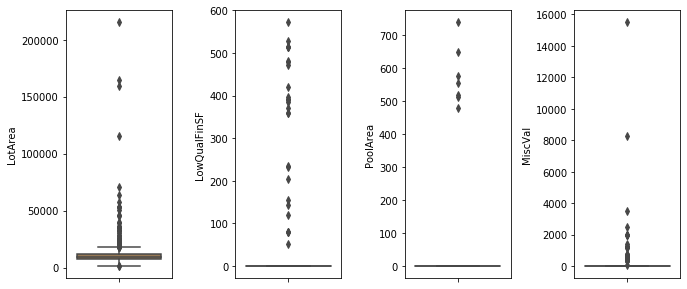

In [92]:
#Box plot to identify Outliers
import seaborn as sns
numeric_variables = ['LotArea','LowQualFinSF','PoolArea','MiscVal']

 #Function to plot the distribution plot of the numeric variable list
def boxplot(var_list):
    plt.figure(figsize=(12,8))
    for var in var_list:
        plt.subplot(2,5,var_list.index(var)+1)
        #plt.boxplot(country[var])
        sns.boxplot(y=var,palette='cubehelix', data=housing_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
boxplot(numeric_variables)

In [93]:
# removing (statistical) outliers for afore-mentioned columns
for i in numeric_variables:
    Q1 = housing_df[i].quantile(0.05)
    Q3 = housing_df[i].quantile(0.95)
    IQR = Q3 - Q1
    housing_df = housing_df[(housing_df[i] >= Q1 - 1.5*IQR) & (housing_df[i] <= Q3 + 1.5*IQR)]

In [94]:
corr= housing_df.corr()

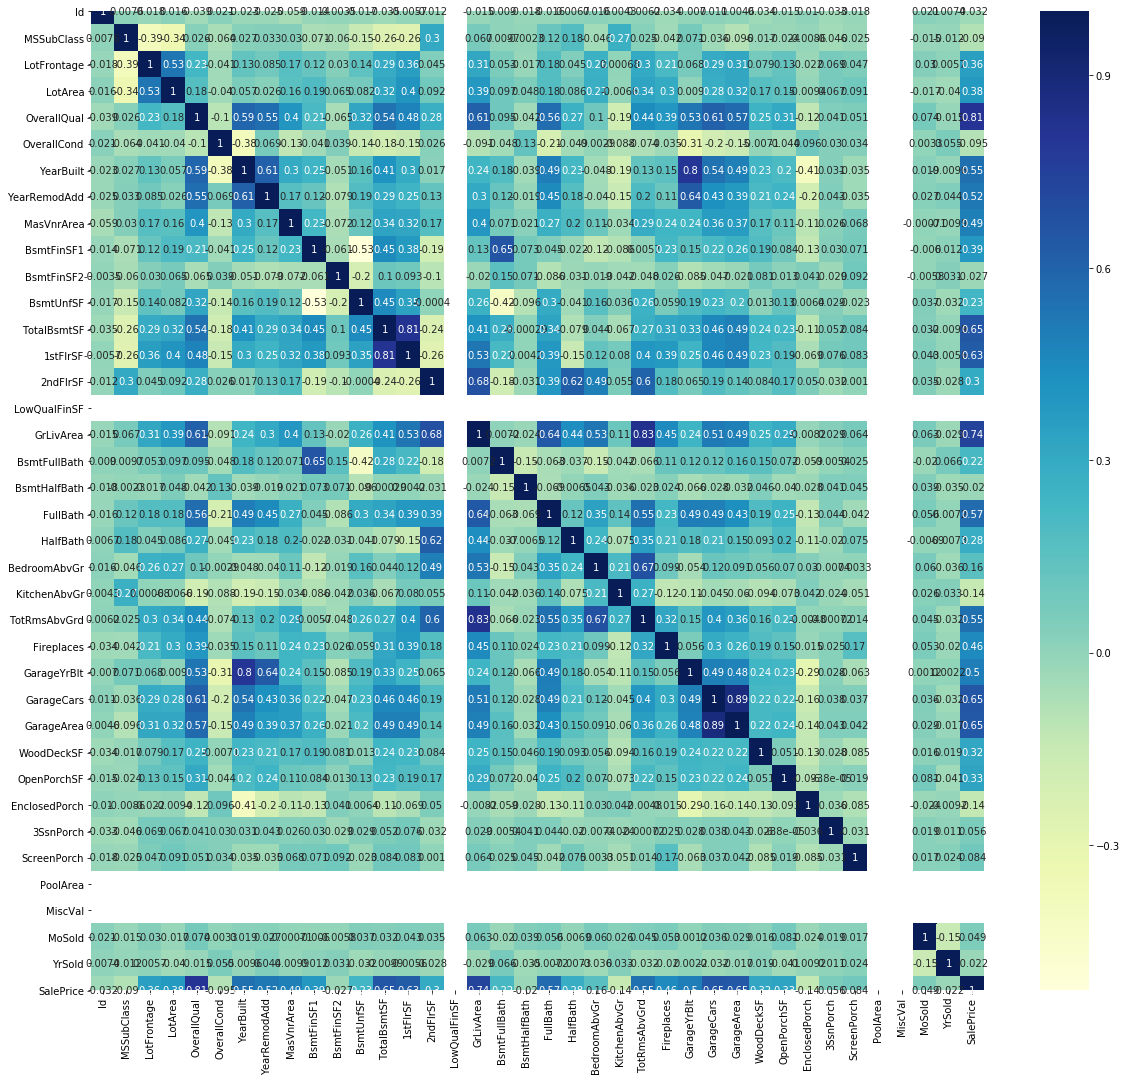

In [172]:
#Finding Correlations
plt.figure(figsize=(20,18))
sns.heatmap(corr,annot=True,cmap="YlGnBu")

From the above heat map, the following correlations are observed which has more than 80% correlation (this list doesn't consider the correlation with target variable)

1. GarageArea with GarageCars
2. 1stFlrSF with TotalBsmtSF
3. GrLivArea with TotRmsAbvGrd
4. GarageYrBlt with YearBlt

Upon checking the data dictionary, the afore-mentioned columns have very similar descriptions.
Hence it is best drop one of them to avoid multi-collinearity

In [95]:
#dropping the one of the correlated columns from each set
corr_col_to_drop = ['GarageCars','1stFlrSF','TotRmsAbvGrd','GarageYrBlt']
housing_df.drop(corr_col_to_drop,axis=1,inplace=True)

In [96]:
#the shape of the data set
housing_df.shape

(1367, 65)

#### Converting some binary variables (Yes/No) to 1/0

In [97]:
# List of variables to map

varlist =  ['CentralAir']

# Defining the map function
def binary_map(x):
    return x.map({'Y': 1, "N": 0})

# Applying the function to the housing list
housing_df[varlist] = housing_df[varlist].apply(binary_map)

In [98]:
#list of columns for which dummies can be applied AND first columns can be dropped
cat_col1 = ['MSZoning','LotShape','LandContour','LotConfig',
            'Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','ExterQual','ExterCond','Foundation',
            'HeatingQC','KitchenQual','Functional','PavedDrive','SaleType','SaleCondition','Exterior2nd','Exterior1st']

dummy1 = pd.get_dummies(housing_df[cat_col1], drop_first=True)

In [99]:
#Replacing Ignorable that we imputed for missing rows with the values that column itself has
housing_df.MasVnrType.replace(to_replace='Ignorable',value='None',inplace=True)
housing_df.BsmtQual.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.BsmtCond.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.BsmtExposure.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.BsmtFinType1.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.BsmtFinType2.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.GarageType.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.GarageFinish.replace(to_replace='Ignorable',value='NA',inplace=True)
housing_df.GarageQual.replace(to_replace='Ignorable',value='NA',inplace=True)

In [100]:
#list of columns where the columns are dropped without drop_first option
cat_col2 = ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'Electrical','GarageType','GarageFinish','GarageQual']
dummy2 = pd.get_dummies(housing_df[cat_col2])

In [101]:
# Adding the results to the master dataframe
housing_df_dummies = pd.concat([housing_df, dummy1], axis=1)
housing_df_dummies = pd.concat([housing_df_dummies, dummy2], axis=1)

In [102]:
#Drop the categorical columns and the dummy columns which are NA or None
dummy_col_drop = ['BsmtQual_NA','BsmtCond_NA','BsmtExposure_NA','BsmtFinType1_NA',
                  'BsmtFinType2_NA','Electrical_Ignorable','GarageType_NA','GarageFinish_NA','GarageQual_NA']
housing_df_dummies.drop(dummy_col_drop,axis=1,inplace=True)
housing_df_dummies.drop(cat_col1,axis=1,inplace=True)
housing_df_dummies.drop(cat_col2,axis=1,inplace=True)

In [103]:
#Some categorical columns are expressed in numbers. They should also be expressed in dummies
cat_col_in_num = ['MSSubClass','OverallQual','OverallCond']
housing_df_dummies[cat_col_in_num]= housing_df_dummies[cat_col_in_num].astype('object')

In [104]:
#creating dummies for these above three columns
dummy_cat_num = pd.get_dummies(housing_df_dummies[cat_col_in_num], drop_first=True)

In [105]:
#concatenating with master data frame
housing_df_dummies_final = pd.concat([housing_df_dummies, dummy_cat_num], axis=1)

In [106]:
#drop original categorical variables
housing_df_dummies_final.drop(cat_col_in_num,axis=1,inplace=True)

In [107]:
#drop ID column
housing_df_dummies_final.drop('Id',axis=1,inplace=True)

### Step 3: Data Modelling

In [108]:
#importing train test package
from sklearn.model_selection import train_test_split

In [109]:
# Splitting the data into train and test
housing_train,housing_test = train_test_split(housing_df_dummies_final, train_size=0.7, test_size=0.3, random_state=100)

#### Feature Scaling

In [110]:
housing_df_dummies_final.select_dtypes(exclude='uint8').columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [111]:
housing_df_dummies_final.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9
0,65.0,8450,2003,2003,196.0,706,0,150,856,1,...,0,0,0,0,0,1,0,0,0,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1,...,0,0,0,0,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,1,...,0,0,0,0,0,1,0,0,0,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,1,...,0,0,0,0,0,1,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1,...,0,0,0,0,0,1,0,0,0,0


In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

col_to_scale = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold','SalePrice']

housing_train[col_to_scale] = scaler.fit_transform(housing_train[col_to_scale])
housing_train.head()


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,...,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9
178,-0.349838,1.975233,1.192557,1.139827,3.561575,3.301959,-0.274186,-0.574267,2.761412,1,...,1,0,0,0,0,1,0,0,0,0
754,-0.453881,-0.439049,-0.116959,0.945607,-0.595438,-0.029503,2.676273,-1.022393,-0.081931,1,...,0,0,0,0,0,0,0,0,1,0
1045,-0.037710,1.023304,-0.587041,-1.482152,-0.595438,-1.027805,-0.274186,-1.283989,-2.533417,1,...,0,0,0,0,0,1,0,0,0,0
1342,-0.037710,-0.071553,0.991093,0.799941,0.232630,-1.027805,-0.274186,1.636789,0.534525,1,...,0,0,0,0,0,1,0,0,0,0
1296,0.534524,-0.243220,-0.318423,-1.093710,0.227073,0.736847,-0.274186,-0.501475,0.142669,1,...,0,0,0,0,0,0,1,0,0,0


In [113]:
# Dropping target variable from X
X_train = housing_train.drop(['SalePrice'], axis=1)

# Putting response variable to y
y_train = housing_train['SalePrice']

#### Model Building and Evaluation

#### Ridge Regression

In [114]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


#instantiate the class
ridge = Ridge()

# cross validation (as seen we use ridge as the estimator and the scoring used is Negative MAE)
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    6.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [115]:
#storing the cross validation results in a new data frame 
#and considering only the values where the alpha parameter is less than or equal to 200
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068159,0.023214,0.010995,0.003631,0.0001,{'alpha': 0.0001},-0.225056,-0.215031,-0.239737,-0.241630,...,-0.229106,0.010090,25,-0.157140,-0.157006,-0.158054,-0.152109,-0.153411,-0.155544,0.002338
1,0.040177,0.007245,0.007591,0.001862,0.001,{'alpha': 0.001},-0.224988,-0.214967,-0.239663,-0.241556,...,-0.229048,0.010080,24,-0.157153,-0.157017,-0.158060,-0.152126,-0.153419,-0.155555,0.002336
2,0.032981,0.004236,0.006400,0.001197,0.01,{'alpha': 0.01},-0.224349,-0.214391,-0.238969,-0.240890,...,-0.228511,0.009994,23,-0.157288,-0.157123,-0.158167,-0.152280,-0.153503,-0.155672,0.002330
3,0.044775,0.009191,0.008994,0.001786,0.05,{'alpha': 0.05},-0.222155,-0.212742,-0.236596,-0.238597,...,-0.226673,0.009655,22,-0.157757,-0.157553,-0.158602,-0.152771,-0.153836,-0.156104,0.002338
4,0.047172,0.013955,0.008001,0.001664,0.1,{'alpha': 0.1},-0.220257,-0.211655,-0.234518,-0.236448,...,-0.225047,0.009260,21,-0.158212,-0.157915,-0.158920,-0.153160,-0.154203,-0.156482,0.002333


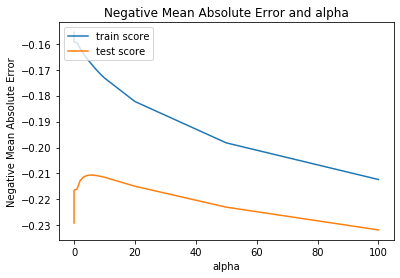

In [116]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [117]:
#displaying the cv_results with selected columns
cv_results[['param_alpha','mean_train_score','mean_test_score']]

,param_alpha,mean_train_score,mean_test_score
0,0,-0.155544,-0.229106
1,0,-0.155555,-0.229048
2,0,-0.155672,-0.228511
3,0,-0.156104,-0.226673
4,0,-0.156482,-0.225047
5,0,-0.157016,-0.222692
6,0,-0.157435,-0.221031
7,0,-0.157812,-0.219809
8,0,-0.158143,-0.218931
9,0,-0.158447,-0.218197


In [118]:
print(model_cv.best_params_)

{'alpha': 6.0}


`As seen from the plot and the data frame above, the optimal alpha that can be chosen is` ***6*** `where the test error is reducing and then starts increasing`

In [119]:
alpha = 6
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 2.66624120e-02,  5.34808148e-02,  1.42288126e-01,  4.63481628e-02,
        3.12116354e-02,  1.16013672e-01,  3.22136554e-03,  1.14229803e-02,
        1.35127170e-01,  6.48173957e-02,  1.89638789e-02,  0.00000000e+00,
        3.12996678e-01,  1.20971342e-02, -6.37272447e-03,  2.97670303e-02,
        2.45013959e-02, -3.42591401e-02, -5.77806879e-02,  2.96612264e-02,
        5.90880792e-02,  2.36487000e-02,  2.22532293e-02,  2.06580451e-02,
        1.50118570e-02,  1.51594273e-02,  0.00000000e+00,  0.00000000e+00,
       -6.37709369e-03,  1.51534853e-03,  1.05959395e-01,  4.43178027e-02,
        8.36142137e-02,  2.93021766e-02,  2.89962991e-02, -3.56818056e-02,
       -1.12716549e-02,  5.39417571e-02, -1.21339835e-01,  7.79379806e-03,
        3.36595449e-02, -4.38141528e-02,  2.60048749e-02, -2.13226532e-02,
        2.37382872e-02,  5.11017283e-02,  5.94434590e-02, -2.06725964e-02,
       -7.97211770e-02,  1.77520417e-01, -1.46258969e-01, -1.07409779e-01,
       -8.39942003e-02, -

In [120]:
#Scaling the test data
housing_test[col_to_scale] = scaler.transform(housing_test[col_to_scale])

In [121]:
# Dropping target variable from X test
X_test = housing_test.drop(['SalePrice'], axis=1)

# Putting response variable to y test
y_test = housing_test['SalePrice']

In [122]:
# predict and compute r2_Score, MSE, MAE
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

#Predicting for the train data set
y_train_pred = ridge.predict(X_train)
print('The R2 score for the train data using ridge regression is '+str(r2_score(y_true=y_train, y_pred=y_train_pred)))
print('The MSE for the train data using ridge regression is '+str(mean_squared_error(y_train, y_train_pred)))
print('The MAE for the train data using ridge regression is '+str(mean_absolute_error(y_train, y_train_pred)))
print('\n')
y_test_pred = ridge.predict(X_test)
print('The R2 score for the test data using ridge regression is '+str(r2_score(y_true=y_test, y_pred=y_test_pred)))
print('The MSE for the test data using ridge regression is '+str(mean_squared_error(y_test, y_test_pred)))
print('The MAE for the test data using ridge regression is '+str(mean_absolute_error(y_test, y_test_pred)))

The R2 score for the train data using ridge regression is 0.9376906711170311
The MSE for the train data using ridge regression is 0.06230932888296889
The MAE for the train data using ridge regression is 0.17050761438440715


The R2 score for the test data using ridge regression is 0.9144663965346922
The MSE for the test data using ridge regression is 0.10682559065144899
The MAE for the test data using ridge regression is 0.1950792629947875


As evident from above results, the Mean absolute error, MSE, R2 score are lesser when we perform regression using ridge and the test data results are in par with train data results.
<br>
Let's try with Lasso regression now

#### Lasso Regression

In [124]:
lasso = Lasso()

# cross validation
model_cvl = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cvl.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    9.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [125]:
lasso_cv_results = pd.DataFrame(model_cvl.cv_results_)
lasso_cv_results[['param_alpha','mean_train_score','mean_test_score']]

,param_alpha,mean_train_score,mean_test_score
0,0.0001,-0.158004,-0.218538
1,0.001,-0.170997,-0.208885
2,0.01,-0.226668,-0.241310
3,0.05,-0.284659,-0.292605
4,0.1,-0.305067,-0.309925
5,0.2,-0.352178,-0.354671
6,0.3,-0.427021,-0.428290
7,0.4,-0.513266,-0.514368
8,0.5,-0.598113,-0.598801
9,0.6,-0.677830,-0.678856


In [127]:
print(model_cvl.best_params_)

{'alpha': 0.001}


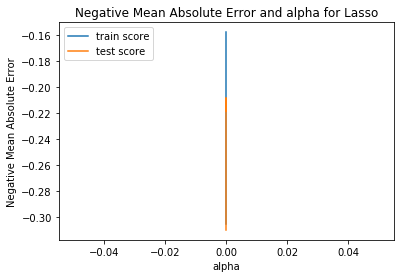

In [130]:
# plotting mean test and train scoes with alpha 
#As seen from best parameters value the optimal alpha is 0.001, hence limiting to first 5 values alone
lasso_plot = lasso_cv_results.head()
lasso_plot['param_alpha'] = lasso_plot['param_alpha'].astype('int32') < 0.1

# plotting
plt.plot(lasso_plot['param_alpha'], lasso_plot['mean_train_score'])
plt.plot(lasso_plot['param_alpha'], lasso_plot['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha for Lasso")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

`As seen from the plot and the data frame above, the optimal alpha that can be chosen is` ***0.001*** `where the test error is reducing and then starts increasing`

In [131]:
#fitting the model again with optimal hyper parameter
alpha =0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [132]:
lasso.coef_

array([ 0.02069993,  0.0530634 ,  0.16513203,  0.04356485,  0.02482102,
        0.09493764, -0.        ,  0.        ,  0.12026595,  0.02702855,
        0.00271948,  0.        ,  0.35000278,  0.01402821, -0.00204677,
        0.02196198,  0.01907012, -0.03427162, -0.06855003,  0.02984779,
        0.05558903,  0.02264183,  0.02351613,  0.01683847,  0.01480849,
        0.0176281 ,  0.        ,  0.        , -0.00562518,  0.00385617,
        0.09315074,  0.        ,  0.05857653, -0.        ,  0.        ,
       -0.        , -0.00958982,  0.        , -0.07739842,  0.        ,
        0.02497435, -0.        ,  0.        , -0.0121735 ,  0.        ,
        0.        ,  0.13709335,  0.        , -0.        ,  0.2685209 ,
       -0.07592539, -0.01426976, -0.        , -0.        , -0.06732113,
       -0.03986434,  0.05929105, -0.        ,  0.24155914,  0.17677662,
       -0.00563307, -0.        , -0.        ,  0.03366526,  0.05073157,
        0.45290382, -0.        ,  0.05511218, -0.        ,  0.09

In [133]:
y_train_pred = lasso.predict(X_train)
print('The R2 score for the train data using lasso regression is '+str(r2_score(y_true=y_train, y_pred=y_train_pred)))
print('The MSE for the train data using lasso regression is '+str(mean_squared_error(y_train, y_train_pred)))
print('The MAE for the train data using lasso regression is '+str(mean_absolute_error(y_train, y_train_pred)))
print('\n')
y_test_pred = lasso.predict(X_test)
print('The R2 score for the test data using lasso regression is '+str(r2_score(y_true=y_test, y_pred=y_test_pred)))
print('The MSE for the test data using lasso regression is '+str(mean_squared_error(y_test, y_test_pred)))
print('The MAE for the test data using lasso regression is '+str(mean_absolute_error(y_test, y_test_pred)))

The R2 score for the train data using lasso regression is 0.9352235768192493
The MSE for the train data using lasso regression is 0.06477642318075069
The MAE for the train data using lasso regression is 0.17471534281355358


The R2 score for the test data using lasso regression is 0.9170117218062181
The MSE for the test data using lasso regression is 0.10364665436775665
The MAE for the test data using lasso regression is 0.19664067355567208


In [138]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
out_list= list(zip(cols, model_parameters))

In [147]:
#Indicating the top 10 features 
house_dct = dict((val, key) for (key, val) in out_list)
for i,j in house_dct.items():
    if i > 0.2:
        print(i,j)

0.35 GrLivArea
0.269 Neighborhood_Crawfor
0.242 Neighborhood_NoRidge
0.453 Neighborhood_StoneBr
0.265 Functional_Typ
0.288 SaleCondition_Partial
0.22 OverallQual_8
0.674 OverallQual_9
0.639 OverallQual_10
0.212 OverallCond_9


In [148]:
# ridge model parameters
model_parametersl = list(ridge.coef_)
model_parametersl.insert(0, ridge.intercept_)
model_parametersl = [round(x, 3) for x in model_parametersl]
cols = X.columns
cols = cols.insert(0, "constant")
out_list1= list(zip(cols, model_parametersl))

In [150]:
#Indicating the top features of ridge regression 
house_dct1 = dict((val, key) for (key, val) in out_list1)
for i,j in house_dct1.items():
    if i > 0.1:
        print(i,j)

0.218 constant
0.142 YearBuilt
0.116 BsmtFinSF1
0.135 BsmtExposure_Gd
0.313 GrLivArea
0.106 MSZoning_FV
0.178 Neighborhood_Crawfor
0.11 Neighborhood_NPkVill
0.186 Neighborhood_NoRidge
0.356 Neighborhood_StoneBr
0.107 Condition1_Norm
0.246 Functional_Typ
0.102 SaleCondition_AdjLand
0.159 SaleCondition_Partial
0.131 Exterior1st_BrkFace
0.392 OverallQual_9
0.251 OverallQual_10
0.213 OverallCond_9


### Top Features of Ridge Model

The below listed numbered list indicates the relative coeefficients for each feature and describes the top 10 features predicted using ridge regression model


1. 0.392	OverallQual_9
2. 0.356	Neighborhood_StoneBr
3. 0.313	GrLivArea
4. 0.251	OverallQual_10
5. 0.246	Functional_Typ
6. 0.218	constant
7. 0.213	OverallCond_9
8. 0.186	Neighborhood_NoRidge
9. 0.178	Neighborhood_Crawfor
10. 0.159	SaleCondition_Partial

### Top Features of Lasso Model

The below listed numbered list indicates the relative coeefficients for each feature and describes the top 10 features predicted using lasso model

1. 0.674 OverallQual_9
2. 0.639 OverallQual_10
3. 0.453 Neighborhood_StoneBr
4. 0.35 GrLivArea
5. 0.288 SaleCondition_Partial
6. 0.269 Neighborhood_Crawfor
7. 0.265 Functional_Typ
8. 0.242 Neighborhood_NoRidge
9. 0.22 OverallQual_8
10. 0.212 OverallCond_9

As evident from above info, both the model have almost predicted the same features though the importance is slightly different.

<br>

***The optimal value of lambda for ridge and lasso regression is 6 and 0.001 respectively***

## Subjective Questions Coding Section

***Question 1***

In [151]:
#Question1

#When the alpha for ridge is doubled
alpha = 12
ridge_q1 = Ridge(alpha=alpha)

ridge_q1.fit(X_train, y_train)
# ridge model parameters
ridge_param_q1 = list(ridge_q1.coef_)
ridge_param_q1.insert(0, ridge_q1.intercept_)
ridge_param_q1 = [round(x, 3) for x in ridge_param_q1]
cols = X.columns
cols = cols.insert(0, "constant")
q1_out_list= list(zip(cols, ridge_param_q1))

In [152]:
ridge_q1_features = dict((val, key) for (key, val) in q1_out_list)
for i,j in ridge_q1_features.items():
    if i > 0.1:
        print(i,j)

0.215 constant
0.129 YearBuilt
0.118 BsmtFinSF1
0.141 TotalBsmtSF
0.307 GrLivArea
0.155 Neighborhood_Crawfor
0.147 Neighborhood_NoRidge
0.122 Neighborhood_NridgHt
0.276 Neighborhood_StoneBr
0.219 Functional_Typ
0.104 SaleType_New
0.14 SaleCondition_Partial
0.111 Exterior1st_BrkFace
0.11 BsmtQual_Ex
0.123 BsmtExposure_Gd
0.326 OverallQual_9
0.176 OverallQual_10
0.157 OverallCond_9


In [153]:
#When alpha for lasso is doubled
alpha =0.002
lasso_q1 = Lasso(alpha=alpha)
lasso_q1.fit(X_train, y_train)
# lasso model parameters
lasso_param_q1 = list(lasso_q1.coef_)
lasso_param_q1.insert(0, lasso_q1.intercept_)
lasso_param_q1 = [round(x, 3) for x in lasso_param_q1]
cols = X.columns
cols = cols.insert(0, "constant")
q1_out_list_lasso= list(zip(cols, lasso_param_q1))

In [155]:
lasso_q1_features = dict((val, key) for (key, val) in q1_out_list_lasso)
for i,j in lasso_q1_features.items():
    if i > 0.1:
        print(i,j)

0.148 YearBuilt
0.112 TotalBsmtSF
0.371 GrLivArea
0.127 Neighborhood_BrkSide
0.243 Neighborhood_Crawfor
0.163 Neighborhood_NoRidge
0.131 BsmtQual_Ex
0.355 Neighborhood_StoneBr
0.274 Functional_Typ
0.309 SaleCondition_Partial
0.143 Exterior1st_BrkFace
0.152 BsmtExposure_Gd
0.207 OverallQual_8
0.668 OverallQual_9
0.582 OverallQual_10


***Question 3***

In [161]:
top_5_features = ['OverallQual_9','OverallQual_10','Neighborhood_StoneBr','GrLivArea','SaleCondition_Partial']
X_train_q3 = X_train.drop(['OverallQual_9','OverallQual_10','Neighborhood_StoneBr','GrLivArea','SaleCondition_Partial'],axis=1)

In [169]:
alpha =0.001
lasso_elim = Lasso(alpha=alpha)
lasso_elim.fit(X_train_q3, y_train)
# lasso model parameters
lasso_param_q = list(lasso_elim.coef_)
lasso_param_q.insert(0, lasso_elim.intercept_)
lasso_param_q = [round(x, 3) for x in lasso_param_q]
cols = X.columns
cols = cols.insert(0, "constant")
q3_out_list_lasso= list(zip(cols, lasso_param_q))

In [170]:
lasso_q3_features = dict((val, key) for (key, val) in q3_out_list_lasso)
for i,j in lasso_q3_features.items():
    if i > 0.1:
        print(i,j)

1.007 constant
0.115 YearBuilt
0.102 BsmtFinSF1
0.305 TotalBsmtSF
0.246 2ndFlrSF
0.201 Neighborhood_CollgCr
0.195 Neighborhood_NWAmes
0.14 Functional_Mod
0.228 SaleType_ConLI
0.158 Exterior2nd_Wd Shng
0.222 OverallCond_4
